In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML


Set up the initial conditions of each star

Units:

$1\mathring{m}=1.9891*10^{41}kg$

$1\mathring{l}=1.5kpc=4.629*10^{19}m$

$1\mathring{v}=5.3556*10^{5}m/s$

$1\mathring{t}=8.6423*10^{13}s$

$G=1$

$v_{intruder}=1000km/s$ (from the video)

$r_{intruder}=28kpc$ (from the video)

$M_1=5*10^{39}kg$

$r_0=11.0575kpc$ (half of the radius)

$v=\sqrt{\frac{GM_1}{r}}$

$a_i=\frac{-GM_i}{(|r-r_i|+\epsilon)^3}(r-r_i), \epsilon=r_0/3$ where $r$ is the position of the particle and $r_i$ is the position of mass i

$0\leq t\leq50\mathring{t}$

In [24]:
#parameters and initial conditions
M1 = 5/198.91       # 5e39 kg
M2 = (2/3)*M1  #mass of moving galaxy (projectile galaxy)
G = 1.0        #gravitational constant
r0 = 44.23/1.5/4       # it has a diameter of 44.23 kpc and the radius is about 2r0
#Lets create the N-Body system for Target galaxy. Lets do 16 rows just like in the paper for now.

r1 = np.array([0.0, 0.0, 0.0]) #(x,y,z)
r2 = np.array([0.0, 0.0, 28/1.5]) #at arbitary distance away from the target galaxy

# Initial velocities of the galaxies
v1 = np.array([0.0, 0.0, 0.0]) #(vx,vy,vz)
v2 = np.array([0.0, 0.0, -10/5.3556]) #at arbitary velocity towards the target galaxy


a1 = np.zeros_like(v1)
a2 = np.zeros_like(v2)

num_rings = 16
particles_per_ring = 24
# Initialize arrays for particle positions and velocities
ring_positions = np.zeros((num_rings * particles_per_ring, 3))

# mean (mu) and standard deviation (sigma)
mu = 8.5    # center of distribution (half of 16)
sigma = 3.0  # standard deviation, which controls the spread of the distribution

#ring_radii = np.random.normal(mu, sigma, num_rings)

ring_radii = np.random.normal(0,r0,num_rings) #μ(r) ∝ exp(-r^2/2r_0^2)

#for positive radii
ring_radii = np.abs(ring_radii) + 0.5*r0

# Distribute particles in rings
for i in range(num_rings):
    for j in range(particles_per_ring):
        # Calculate position in polar coordinates
        theta = 2 * np.pi * j / particles_per_ring
        r = ring_radii[i]
        
        # Convert to Cartesian coordinates
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        z = 0.0
        
        # Store position in array
        ring_positions[i * particles_per_ring + j] = [x, y, z]  # Use 3 components here

#adjust the size of the galaxy
max_dist = np.max(np.linalg.norm(ring_positions,axis=1))
ring_positions /= max_dist
ring_positions *= 1.5*r0

#lets give a volocity to each particle in the rings so that they are in circular orbits
ring_velocities = np.zeros((num_rings * particles_per_ring, 3))

# Calculate circular velocity of each ring
ring_vels = np.sqrt(G * M1 / ring_radii)

# Set initial velocities of particles in rings
for i in range(num_rings):
    for j in range(particles_per_ring):
        # Calculate position in polar coordinates
        theta = 2 * np.pi * j / particles_per_ring
        v = ring_vels[i]
        
        
        # Convert to Cartesian coordinates
        vx = v * np.cos(theta+np.pi/2)
        vy = v * np.sin(theta+np.pi/2)
        vz = 0.0
        
        # Store velocity in array
        ring_velocities[i * particles_per_ring + j] = [vx, vy, vz]  # Use 3 components here
        
#rescale the velocities

positions = ring_positions
velocities = ring_velocities *3
accelerations = np.zeros_like(velocities)

Plot the initial conditions

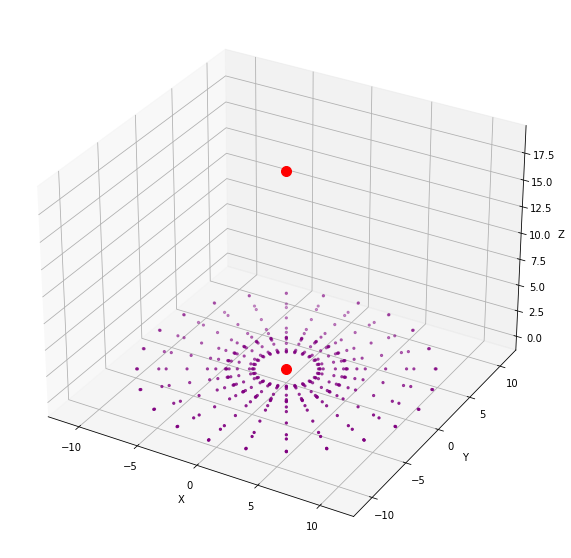

In [25]:
# 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(ring_positions[:, 0], ring_positions[:, 1], ring_positions[:, 2], c="purple", s=5)
ax.scatter(r1[0], r1[1], r1[2], c="red", s=100)
ax.scatter(r2[0], r2[1], r2[2], c="red", s=100)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [26]:
def get_a(pos):
    r_r1 = pos - r1 # position vector from M1 to the star
    r_mag1 = np.linalg.norm(r_r1)
    r_r2 = pos - r2 # position vector from M2 to the star
    r_mag2 = np.linalg.norm(r_r2)
    a = -G*M1/(r_mag1 + epsilon)**3*r_r1 -G*M2/(r_mag2 + epsilon)**3 * r_r2
    
    return a

def accel(a1,a2):
    for i in range(len(positions)):  # update the accelerations of each star
        accelerations[i] = get_a(positions[i])
    r = r2 - r1 # position vector from M1 to the M2
    r_mag = np.linalg.norm(r)
    a1 = G*M2/(r_mag + epsilon)**3 * r # update the accelerations of the masses
    a2 = -G*M1/(r_mag + epsilon)**3 * r
    return a1,a2

In [27]:
def plot(t):
  # 3D plot
    plt_size = 50
    fig = plt.figure(figsize=(20,20))
    ax = plt.axes(projection = '3d')
    ax.scatter(r1[0],r1[1],r1[2],c='red',s=100)
    ax.scatter(positions[:,0],positions[:,1],positions[:,2],c='blue',s=1)
    ax.scatter(r2[0],r2[1],r2[2],c='red',s=100)
    plt.xlim([-plt_size,plt_size])
    plt.ylim([-plt_size,plt_size])
    ax.set_zlim(-plt_size,plt_size)
    plt.show()

    #2D plot
    plt.scatter(positions[:,0],positions[:,1],s=1)
    plt.xlim([-plt_size,plt_size])
    plt.ylim([-plt_size,plt_size])
    #plt.savefig(str(t)+'.png')

t = 0
T = 50
dt = 0.05
epsilon = r0/3


pos1 = []
pos2 = []

all_pos = []

while t<T: # leapfrog
    #print(t)
    pos1.append(np.copy(r1))
    pos2.append(np.copy(r2))
    all_pos.append(np.copy(positions))
    #plot(t)
        
    a1,a2 = accel(a1,a2)
    
    for i in range(len(positions)):
        velocities[i,:2] = velocities[i,:2] + 0.5 * dt * accelerations[i,:2] # update the velocities of the stars
        velocities[i,2] = velocities[i,2] + 0.5 * dt * accelerations[i,2] * 500
        
    v1 = v1 + 0.5 * dt * a1 # update the velocities of the masses
    v2 = v2 + 0.5 * dt * a2
    
    for i in range(len(positions)):
        positions[i] = positions[i] + dt * velocities[i]
        
    r1 = r1 + dt * v1
    r2 = r2 + dt * v2
    
    a1,a2 = accel(a1,a2)
    
    for i in range(len(positions)):
        #velocities[i] = velocities[i] + 0.5 * dt * accelerations[i]
        velocities[i,:2] = velocities[i,:2] + 0.5 * dt * accelerations[i,:2] # update the velocities of the stars
        velocities[i,2] = velocities[i,2] + 0.5 * dt * accelerations[i,2] * 500
        
    v1 = v1 + 0.5 * dt * a1 # update the velocities of the masses
    v2 = v2 + 0.5 * dt * a2
    
    t += dt

'''
plt.plot(pos1)
plt.plot(pos2)

plt.show()

plt.plot(vel1)
plt.plot(vel2)
plt.show()
plt.plot(acc1)
plt.plot(acc2)
'''

'\nplt.plot(pos1)\nplt.plot(pos2)\n\nplt.show()\n\nplt.plot(vel1)\nplt.plot(vel2)\nplt.show()\nplt.plot(acc1)\nplt.plot(acc2)\n'

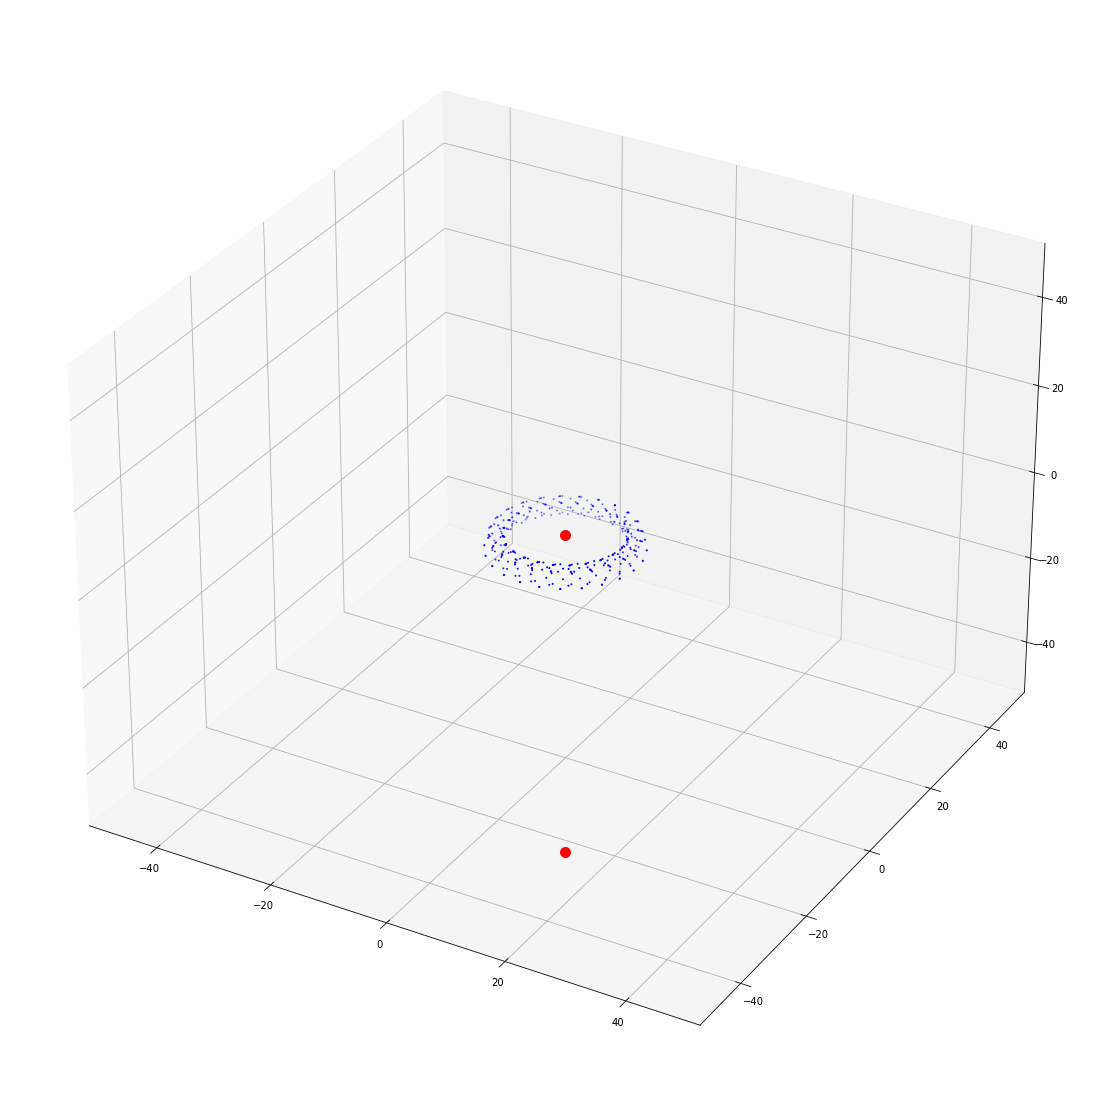

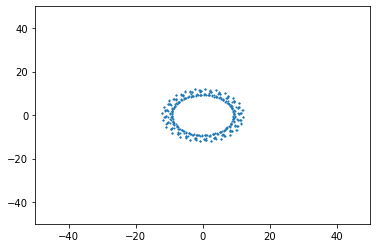

In [28]:
plot(1)

In [29]:
all_pos = np.array(all_pos)
print(all_pos.shape)

pos1 = np.array(pos1)
print(pos1.shape)

pos2 = np.array(pos2)
print(pos2.shape)

(1001, 384, 3)
(1001, 3)
(1001, 3)


In [ ]:
#xy plane animation
fig_width = 20  # Width in inches
fig_height = 20  # Height in inches

# Calculate the figure size in pixels
dpi = 100  # Dots per inch (adjust as needed)
fig_size = (fig_width * dpi, fig_height * dpi)

# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Create an empty line object
scatter = ax.scatter(all_pos[0,:,0], all_pos[0,:,1],s=1)

# Initialization function
def init():
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    return scatter,

# Update function
def update(frame):
    x = all_pos[frame,:,0]
    y = all_pos[frame,:,1]
    scatter.set_offsets(np.column_stack((x, y)))
    scatter.set_sizes([1]*len(x))
    return scatter,

# Create animation
animation = FuncAnimation(fig, update, frames=1000, init_func=init, blit=True, interval = 20)

# Save animation as a GIF
animation.save('animation_xy_plane.gif', writer='imagemagick')
#HTML(animation.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
#xz plane animation
fig_width = 20  # Width in inches
fig_height = 20  # Height in inches
num_particles = num_rings * particles_per_ring

# Calculate the figure size in pixels
dpi = 100  # Dots per inch (adjust as needed)
fig_size = (fig_width * dpi, fig_height * dpi)

# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

x = np.zeros((1001,num_particles+2))
x[:,:num_particles] = all_pos[:,:,0]
x[:,num_particles] = pos1[:,0]
x[:,num_particles+1] = pos2[:,0]

z = np.zeros((1001,num_particles+2))
z[:,:num_particles] = all_pos[:,:,2]
z[:,num_particles] = pos1[:,2]
z[:,num_particles+1] = pos2[:,2]

sizes = ([1]*num_particles)
sizes.append(100)
sizes.append(100)

colors = ['blue']*num_particles
colors.append('red')
colors.append('red')

# Create an empty line object
scatter = ax.scatter(x[0],z[0],s=sizes,c=colors)

# Initialization function
def init():
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    return scatter,

# Update function
def update(frame):
    scatter.set_offsets(np.column_stack((x[frame], z[frame])))
    return scatter,

# Create animation
animation = FuncAnimation(fig, update, frames=1000, init_func=init, blit=True, interval = 20)

# Save animation as a GIF
animation.save('animation_xz_plane.gif', writer='imagemagick')
#HTML(animation.to_jshtml())

In [ ]:
#3d animation
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

x = np.zeros((1001,num_particles+2))
x[:,:num_particles] = all_pos[:,:,0]
x[:,num_particles] = pos1[:,0]
x[:,num_particles+1] = pos2[:,0]

y = np.zeros((1001,num_particles+2))
y[:,:num_particles] = all_pos[:,:,1]
y[:,num_particles] = pos1[:,1]
y[:,num_particles+1] = pos2[:,1]

z = np.zeros((1001,num_particles+2))
z[:,:num_particles] = all_pos[:,:,2]
z[:,num_particles] = pos1[:,2]
z[:,num_particles+1] = pos2[:,2]

sizes = ([1]*num_particles)
sizes.append(100)
sizes.append(100)

colors = ['blue']*num_particles
colors.append('red')
colors.append('red')
'''
x = np.append(all_pos[:,:,0],[pos1[:,0]],axis=0)

x = np.append(x,[pos2[:,0]],axis=0)
y = np.append(all_pos[:,:,1],[pos1[:,1]],axis=0)
y = np.append(x,[pos2[:,1]],axis=0)
z = np.append(all_pos[:,:,2],[pos1[:,2]],axis=0)
z = np.append(x,[pos2[:,2]],axis=0)
'''
# Define the initial 3D scatter plot.
scatter = ax.scatter(x[0],y[0],z[0], s=sizes,c=colors)
'''
scatter_galaxy1 = ax.scatter(pos1[0][0], pos1[0][1], pos1[0][2], s=100, color='red')
scatter_galaxy2 = ax.scatter(pos2[0][0], pos2[0][1], pos2[0][2], s=100, color='blue')
'''

# Set plot limits
ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.set_zlim(-25, 25)

def update(frame):
    scatter._offsets3d = (x[frame], y[frame], z[frame])
    #scatter.set_array(colors)
    return scatter,

animation = FuncAnimation(fig, update, frames=1000, interval=20, blit=True)
animation.save('animation3d.gif', writer='imagemagick')
#HTML(animation.to_jshtml())
